### Import modules

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
# show plots in the notebook
%matplotlib inline

### Data pre-processing
Let's import dataset and add a binary column affair

In [5]:
#load dataset
fair_dta = sm.datasets.fair.load_pandas().data
# print (type(fair_dta))

#add "affair" column where : 1 represents affair, 0 represent no affair
fair_dta['affair'] = (fair_dta.affairs > 0).astype(int)

#fair_dta.describe()

### Data Exploration

In [6]:
fair_dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


As expected women who have affair rate thier marriage lower on average.

In [7]:
fair_dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


As increase in age, years married and children coorelate with declining marriage rate.

### Data visualization

Histogram of education and marriage rating

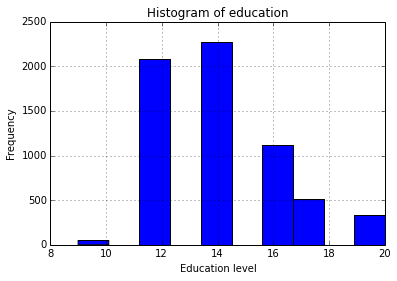

In [8]:
#Histogram of education level
fair_dta.educ.hist()
plt.title('Histogram of education')
plt.xlabel('Education level')
plt.ylabel('Frequency')

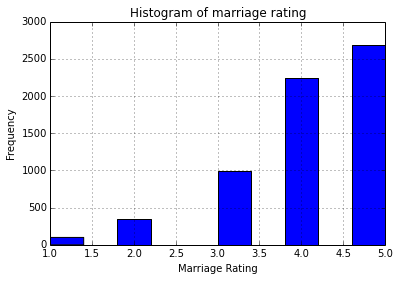

In [9]:
#Histogram of marriage rating
fair_dta.rate_marriage.hist()
plt.title('Histogram of marriage rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's take a look at coorelation between affair and marriage rating

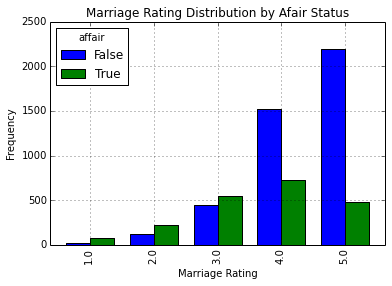

In [10]:
#bar plot of marriage rating and affair (true or false)
pd.crosstab(fair_dta.rate_marriage, fair_dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Afair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Using stacked barplot to look at the percentage of women having affair by number of years of marriage.

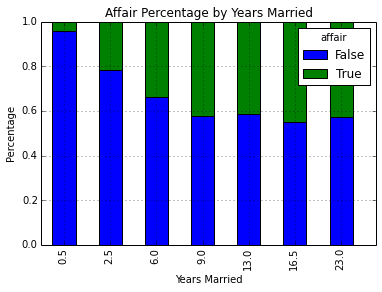

In [11]:
affair_yrs_married = pd.crosstab(fair_dta.yrs_married, fair_dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

### Prepare Data for Logistic Regresion

Let's add an intercept column and a dummy variables for occupation and occupation_husb, since, I'm treating them as categorical variables. Using dmatrices variable from patsy module.

In [12]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                    religious + educ + C(occupation) + C(occupation_husb)',
                fair_dta, return_type='dataframe')
print (X.columns)

Index([u'Intercept', u'C(occupation)[T.2.0]', u'C(occupation)[T.3.0]', u'C(occupation)[T.4.0]', u'C(occupation)[T.5.0]', u'C(occupation)[T.6.0]', u'C(occupation_husb)[T.2.0]', u'C(occupation_husb)[T.3.0]', u'C(occupation_husb)[T.4.0]', u'C(occupation_husb)[T.5.0]', u'C(occupation_husb)[T.6.0]', u'rate_marriage', u'age', u'yrs_married', u'children', u'religious', u'educ'], dtype='object')


In [28]:
#fix column names
X = X.rename(columns = {'C(occupation)[T.2.0]':'occu_2',
                       'C(occupation)[T.3.0]':'occu_3',
                       'C(occupation)[T.4.0]':'occu_4',
                       'C(occupation)[T.5.0]':'occu_5',
                       'C(occupation)[T.6.0]':'occu_6',
                       'C(occupation_husb)[T.2.0]':'occu_husd_2',
                       'C(occupation_husb)[T.3.0]':'occu_husd_3',
                       'C(occupation_husb)[T.4.0]':'occu_husd_4',
                       'C(occupation_husb)[T.5.0]':'occu_husd_5',
                       'C(occupation_husb)[T.6.0]':'occu_husd_6'})


We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [14]:
#flattern y into a 1-D array
y = np.ravel(y)

### Logistic Regression
Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [15]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.72588752748978946


73% accuracy seems good, but what's the null error rate?

In [16]:
y.mean()

0.32249450204209867

([<matplotlib.patches.Wedge at 0x7fbd9cd8e1d0>,
  <matplotlib.text.Text at 0x7fbd9cd9a9d0>])

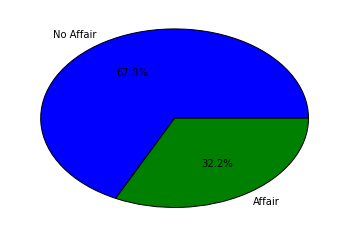

In [17]:
no_affair, affairs = float(len(y) - np.count_nonzero(y))* 100 / float(len(y)), float(np.count_nonzero(y))*100/float(len(y))
sizes = [no_affair, affairs]
labels = 'No Affair', 'Affair'
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.
Let's examine the coefficients to see what we learn.

In [18]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.48986214923]
1,occu_2,[0.188041521947]
2,occu_3,[0.498919714822]
3,occu_4,[0.250640990053]
4,occu_5,[0.838976932692]
5,occu_6,[0.83400830339]
6,occu_husd_2,[0.190579893537]
7,occu_husd_3,[0.297779843131]
8,occu_husd_4,[0.161353493872]
9,occu_husd_5,[0.187717838451]


### Model Evaluation Using a Validation Set
So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [19]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
# Predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[ 1.  0.  0. ...,  0.  0.  0.]


In [21]:
# Generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[ 0.35148525  0.64851475]
 [ 0.90955539  0.09044461]
 [ 0.72569407  0.27430593]
 ..., 
 [ 0.55730636  0.44269364]
 [ 0.81211049  0.18788951]
 [ 0.74732836  0.25267164]]


As you can see, the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.
Now let's generate some evaluation metrics.

In [22]:
# Generate evaluation matrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.729319371728
0.745948078253


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.
We can also see the confusion matrix and a classification report with other metrics.

In [23]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[1169  134]
 [ 383  224]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.46       607

avg / total       0.71      0.73      0.71      1910



/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


### Model Evaluation using cross validation
Now let's try 10-fold cross validation

In [24]:
# 10 fold cross validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
0.724163068551


Looks good. It's still performing at 73% accuracy.
### Predicting the Probability of an Affair
Just for fun, let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [25]:
model.predict_proba(np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,
                              16]))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.77472403,  0.22527597]])


The predicted probability of an affair is 23%.